# Smoke Detector Prediction

## Introduction

Many states in America require homes to have smoke detectors, as fire has caused thousands of deaths in the country. Between 2011 and 2019, fire-related deaths accounted for approximately 7% of the U.S. population [1]. Having a working and sensitive smoke detector can save lives.

Smoke detectors are not limited to homes; they can be used in manufacturing facilities, school buildings, and other locations.

Smoke detectors work by detecting particles in the air. There are two types of smoke detectors: ionization and photoelectric. Ionization detectors detect current reduction as particles get trapped between the two plates in the detector. Photoelectric detectors detect the amount of light bounce when there are no particles present and when there are particles present [2]. In this project, we analyze data from photoelectric smoke detectors.

Project goal: to build a model to predict the state of the alarm on or off using the window of sensor data preceding the prediction."

## Libraries

In [1]:
# Data processsing
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

# Setting seed for reproducibility
np.random.seed(100)  
PYTHONHASHSEED = 0

## Data

The data used in this project is smoke detection dataset from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset).
<br/><br/>
The dataset features in detail:

* Air Temperature
* Air Humidity
* TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
* eCO2: co2 equivalent concentration; calculated from different values like TVCO
* Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
* Raw Ethanol: raw ethanol gas (Source)
* Air Pressure
* PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
* Fire Alarm: ground truth is "1" if a fire is there
* CNT: Sample counter
* UTC: Timestamp UTC seconds
* NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);

In [2]:
df_all = pd.read_csv("smoke_detection_iot.csv")
df_all

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [3]:
#Drop Unnamed since the data look like it is the number of rows
df = df_all.drop(['Unnamed: 0'], axis=1)

In [4]:
# verifying that the unnamed column has been dropped.
# getting info about the data types in the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.2 MB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04
PM2.5,62630.0,1.844678e+02,1976.305615,0.000000e+00,1.340000e+00,1.880000e+00,2.180000e+00,4.543226e+04


This table provides overall data landscape in terms of data distribution.

## Data Exploration

### Missing & Duplicate Data

In [6]:
# Check for missing data
df.isna().sum()

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

In [7]:
# Check for null values
df.isnull().values.any()

False

In [8]:
# Check for duplicates
df.duplicated().sum()

0

### Correlation

In [9]:
df.corr()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
UTC,1.000000,-0.164174,-0.391907,0.180731,0.132100,-0.151088,0.166555,-0.434375,0.123168,0.105304,0.130288,0.103695,0.083234,-0.251595,-0.389404
Temperature[C],-0.164174,1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.089850,-0.163902
Humidity[%],-0.391907,-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.251965,0.399846
TVOC[ppb],0.180731,0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.057703,-0.214743
eCO2[ppm],0.132100,0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.106681,-0.097006
Raw H2,-0.151088,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,-0.031036,0.107007
Raw Ethanol,0.166555,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.511995,-0.340652
Pressure[hPa],-0.434375,-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.186290,0.249797
PM1.0,0.123168,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.093700,-0.110552
PM2.5,0.105304,0.032084,-0.178882,0.477424,0.572691,-0.431079,-0.393192,-0.243071,0.956118,1.000000,0.798873,0.999787,0.969382,-0.083869,-0.084916


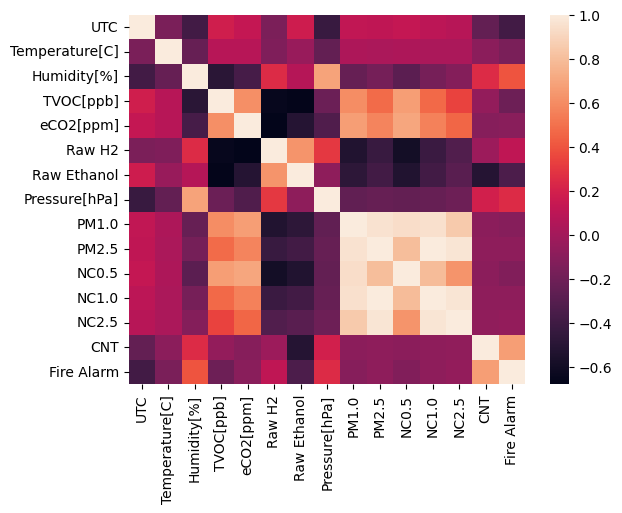

In [10]:
matrix_map=round(df.corr(),2)
sns.heatmap(matrix_map);

PM1, PM 2.5, NC 0.5, NC1 and NC 2.5 are highly correlated. Therefore, including one from each categlory typicall is good enough.

<AxesSubplot: >

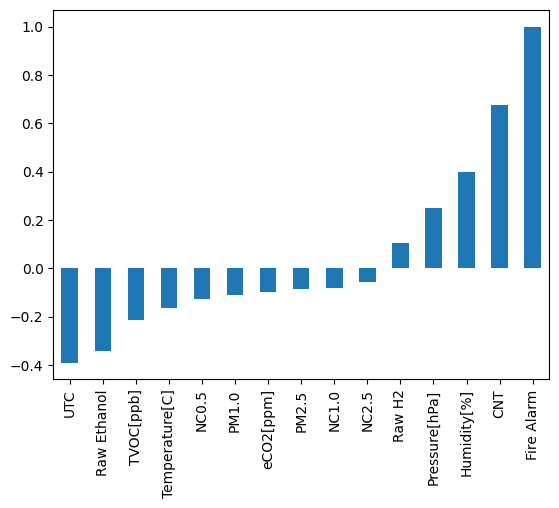

In [11]:
df.corr()['Fire Alarm'].sort_values().plot(kind='bar')

### Variance Inflation Factor (VIF)

In [12]:
#Calculating VIF
vif_df = pd.DataFrame()
vif_df['variable'] = df.columns 

#VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

#VIF for each predictor variable 
sorted_vif_df = vif_df.sort_values(by='VIF', ascending=False)
sorted_vif_df

,variable,VIF
11,NC1.0,1.684848e+12
12,NC2.5,6.676945e+11
9,PM2.5,4.599264e+11
8,PM1.0,9.729414e+10
10,NC0.5,7.383798e+10
0,UTC,1.453114e+06
6,Raw Ethanol,8.021379e+00
3,TVOC[ppb],5.178557e+00
2,Humidity[%],3.486638e+00
5,Raw H2,3.435355e+00


* VIF = 1: There is no correlation between the predicted variable and predictor variables.
* VIF between 1 and 5: There is moderate correlation between the predicted variable and other predictor variables.
* VIF > 5: There is severe correlation between a given predicted variable and other predictor variables in the model.
* Conclusion: NCs, PMs and UTC are highly correlated as seen in the heatmap
* *Note: &nbsp; analysis based on "How to Test for Multicollinearity in Python" by Zach [3].

### Data Distribution

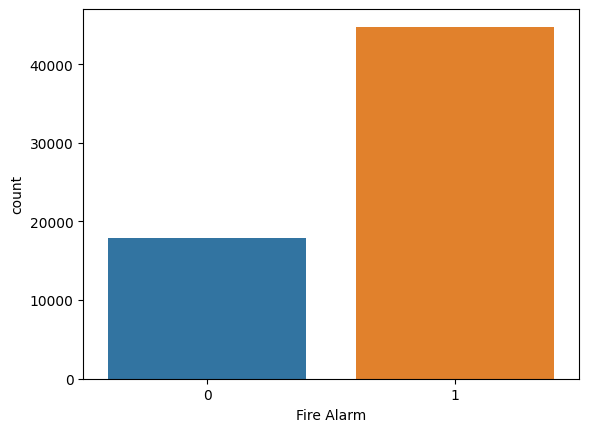

In [13]:
g=sns.countplot(x = df["Fire Alarm"])
plt.show()

Fire Alarm: ground truth is "1" if a fire is there and "0" if no fire is there.

So data with fire alarm went off is close to half of data without fire alarm went off. We have class imbalance in our data. This could create bias when we feed this data to the model. The model will likely to predict the alarm do not went off.

### Data Insights

Anomaly detection refers to the process of identifying unusual patterns or observations in your data that deviate from the expected behavior. In the context of time series data from a smoke detector, we can use anomaly detection techniques to identify abnormal readings from the sensors that may indicate a potential fire.

Potential indicators:
Abnormal readings in temperature or humidity sensors.
Abnormal readings in the levels of smoke or carbon monoxide in the air.
An increase in the frequency of false alarms.
An unexpected change in the pattern of sensor readings.
An outlier in the readings from one or more sensors.

By detecting these anomalies, the smoke detector makes sound to alert users and prevent a fire from occurring.

To build a model that gives prediction about the accuracy of the alarm, we explore the data to understand the relationship between the features and the prediction.

Since the data is highly imbalanced, the model we build will likely predict 1 for Fire Alarm than 0.

## Data Visualization

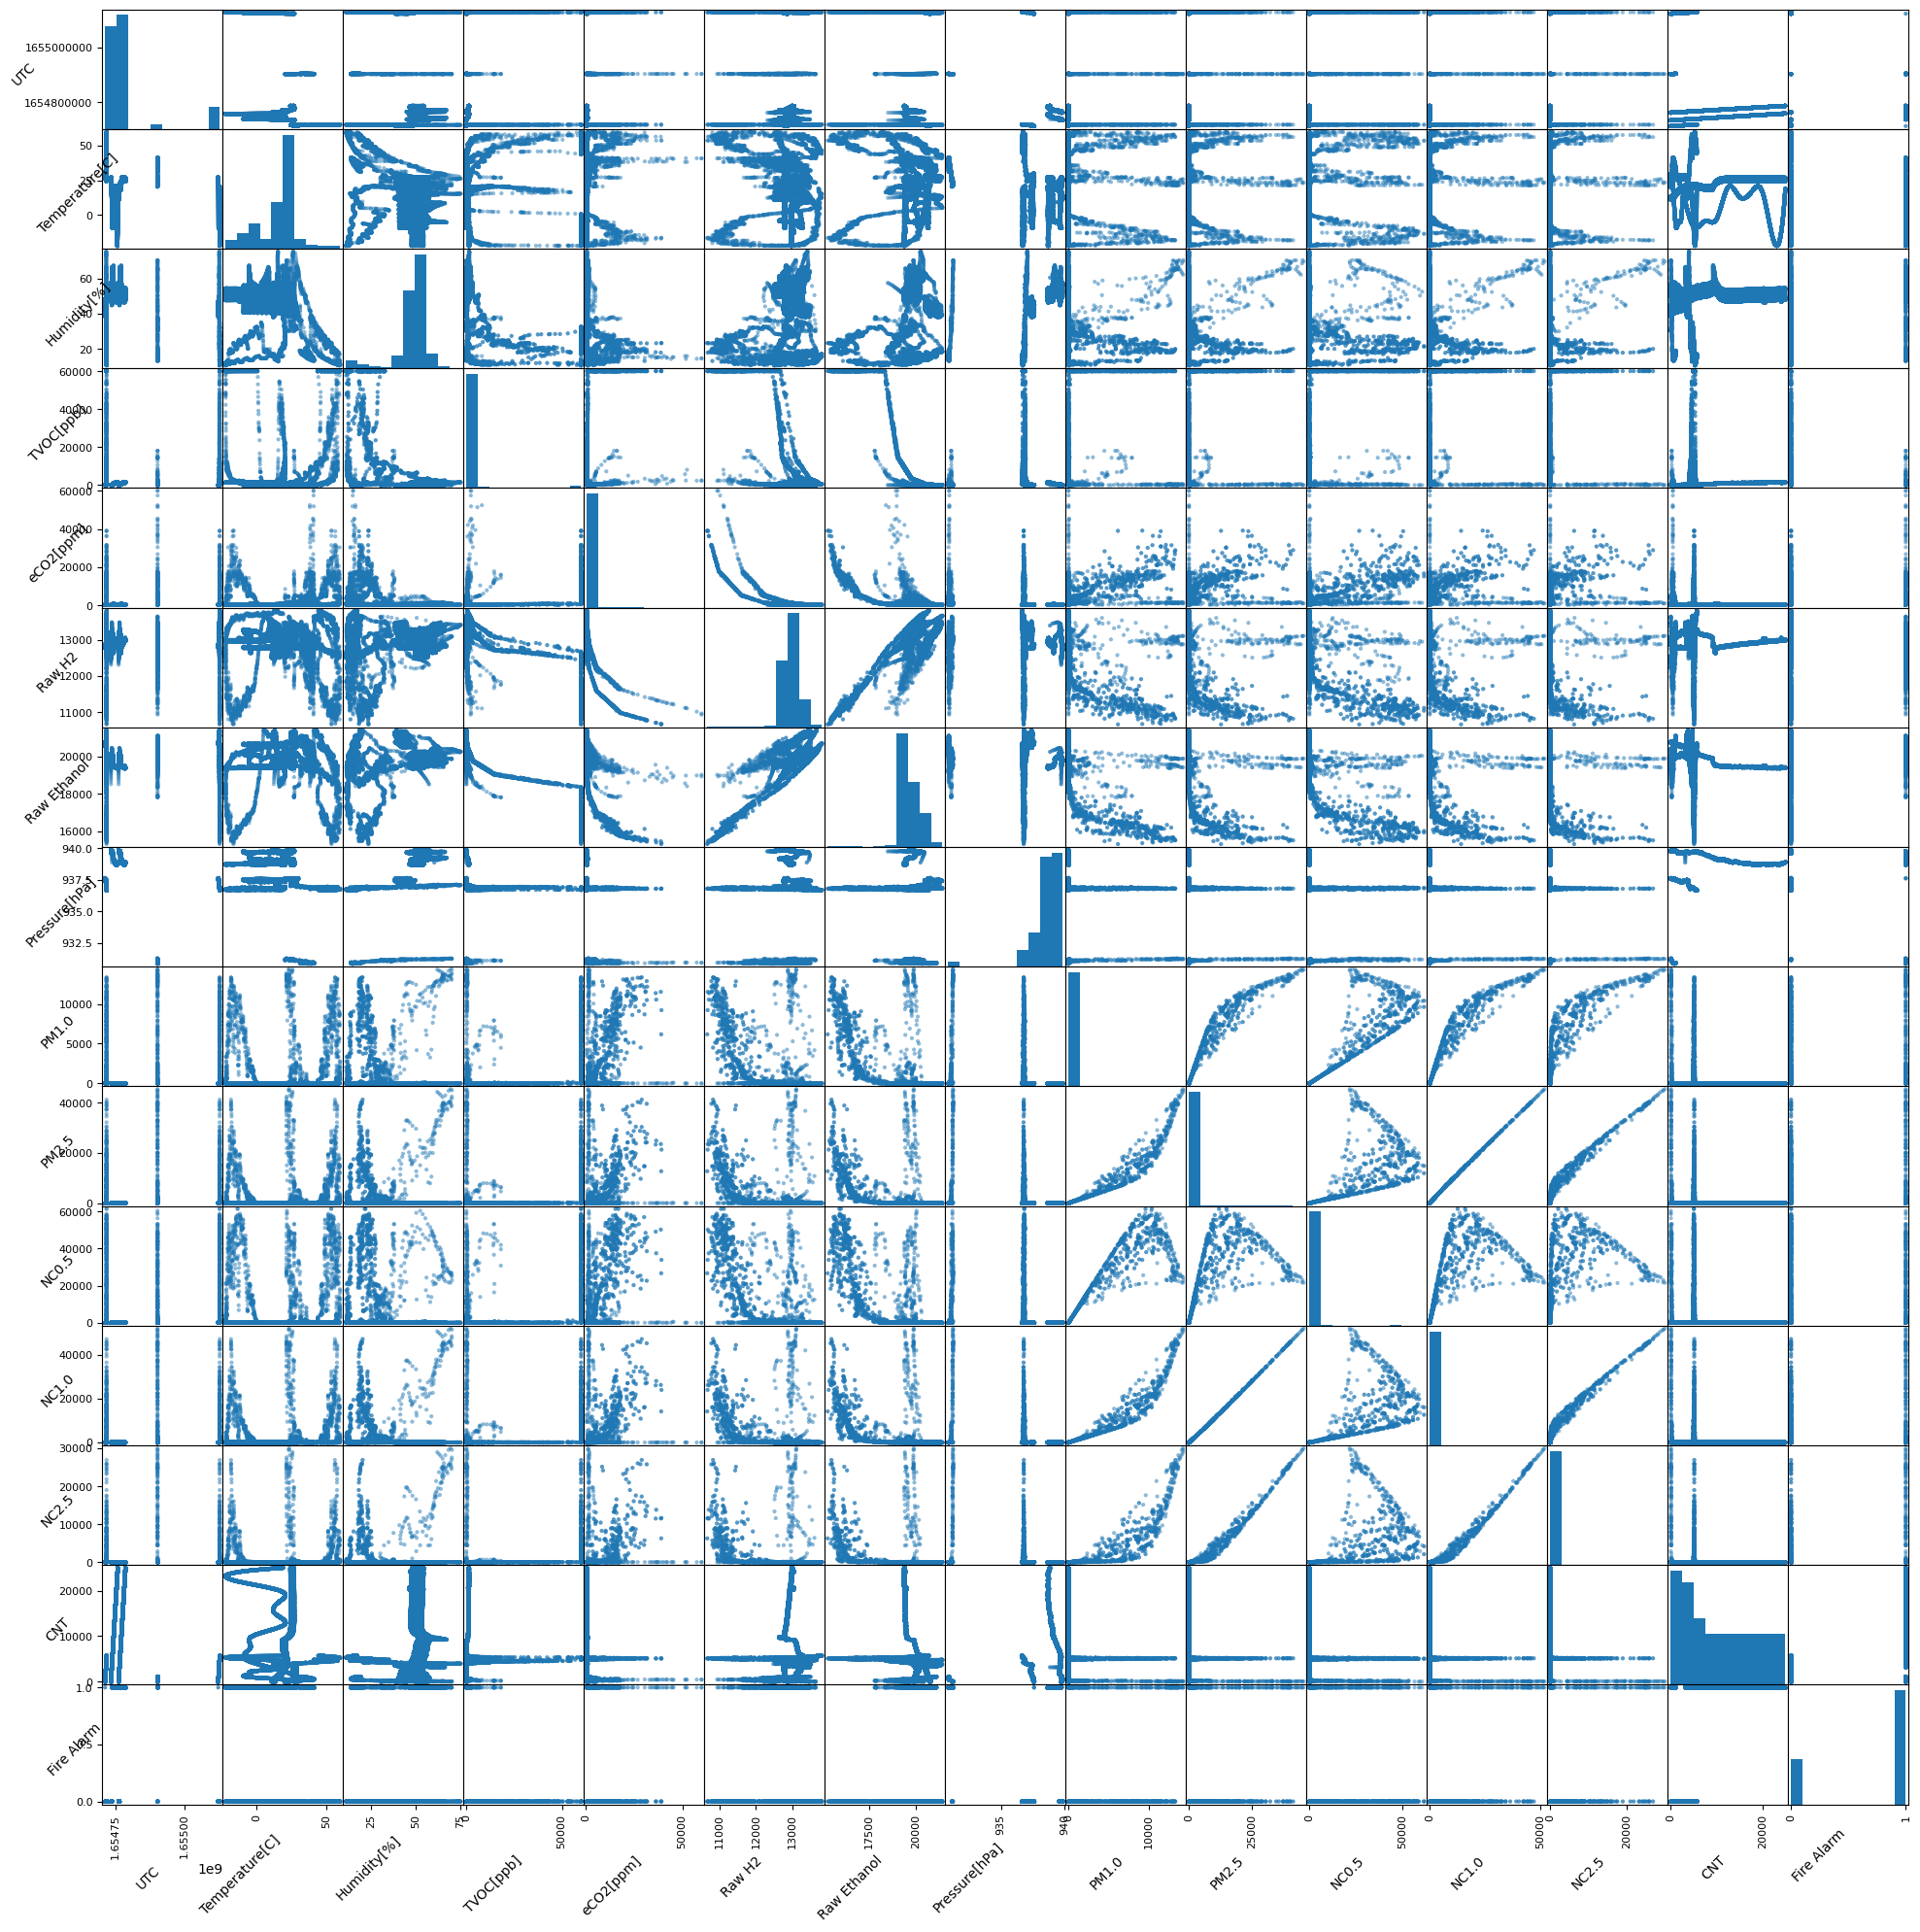

In [14]:
#Scatter Plot
scatter_matrix = pd.plotting.scatter_matrix(df, figsize  = [24, 24]);

# Rotate the x-axis and y-axis labels by 45 degrees
for ax in scatter_matrix.ravel():
    # Rotate x-axis labels
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    
    # Rotate y-axis labels
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_va('top')

In [15]:
# Let y be the Fire Alarm outcome (1:yes, 0:no)
# Let x be the features
y = df['Fire Alarm']
x = df.drop(['Fire Alarm'], axis =1)

In [16]:
column_list = []
for i in df.columns:
    column_list.append(i)
features = column_list[:-1]
features

['UTC',
 'Temperature[C]',
 'Humidity[%]',
 'TVOC[ppb]',
 'eCO2[ppm]',
 'Raw H2',
 'Raw Ethanol',
 'Pressure[hPa]',
 'PM1.0',
 'PM2.5',
 'NC0.5',
 'NC1.0',
 'NC2.5',
 'CNT']

UTC


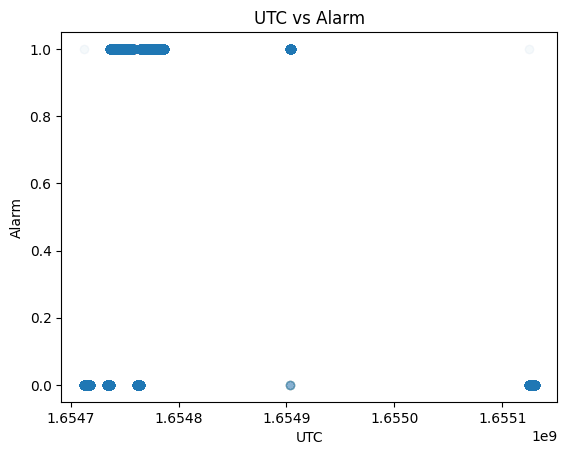

Temperature[C]


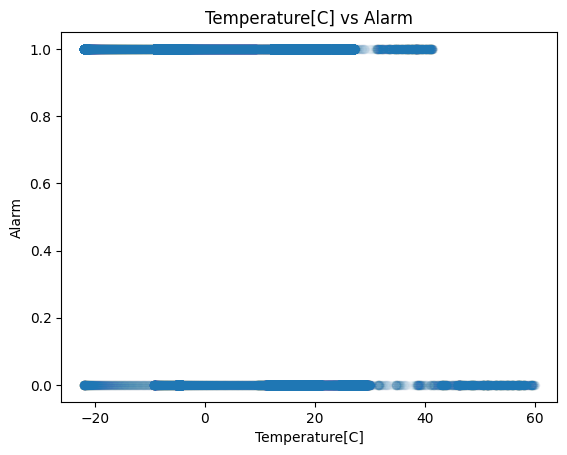

Humidity[%]


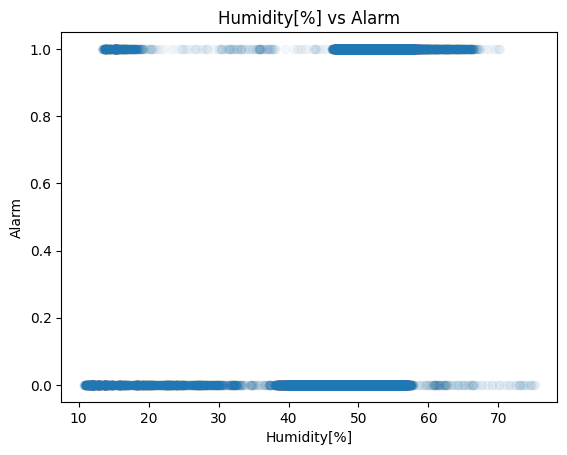

TVOC[ppb]


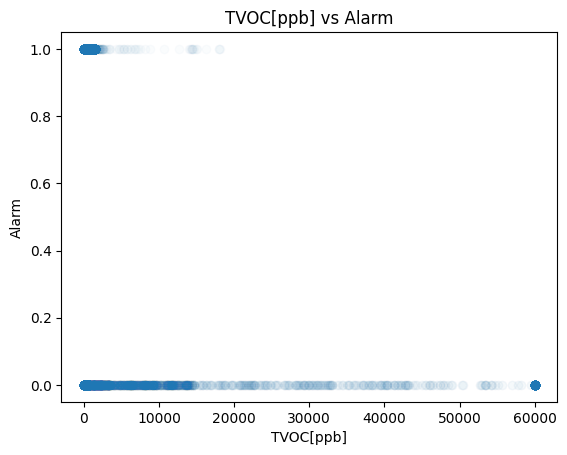

eCO2[ppm]


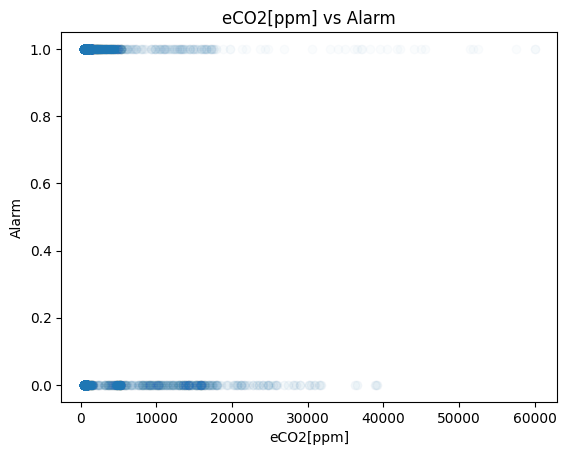

Raw H2


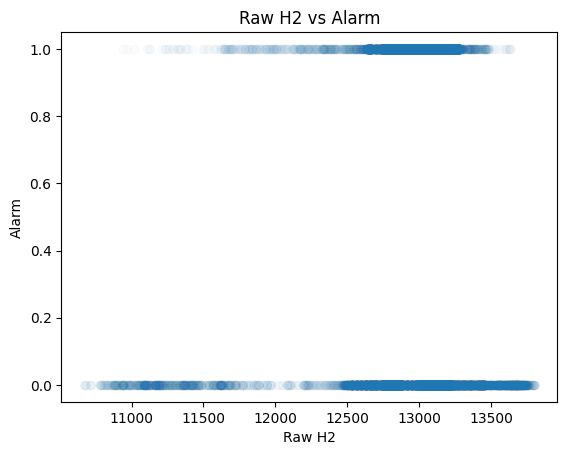

Raw Ethanol


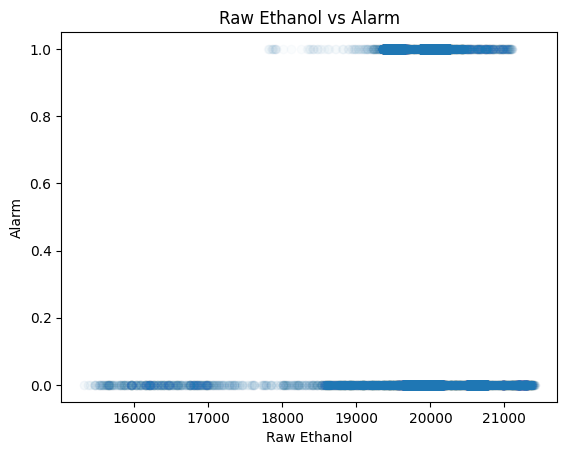

Pressure[hPa]


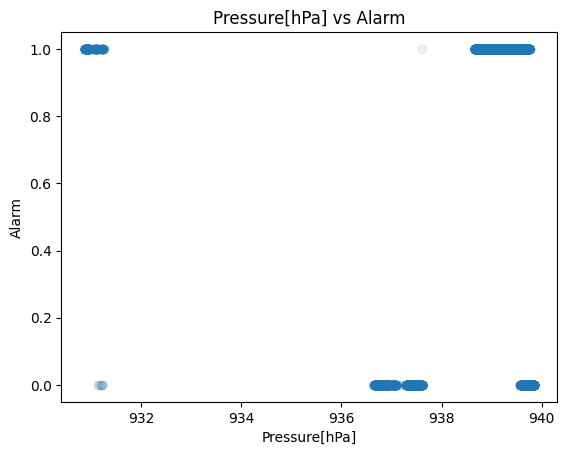

PM1.0


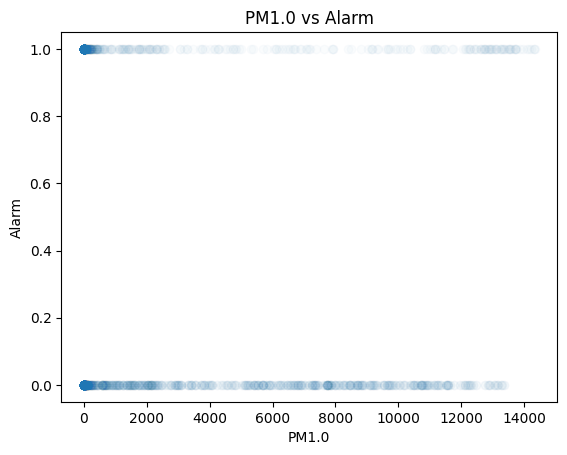

PM2.5


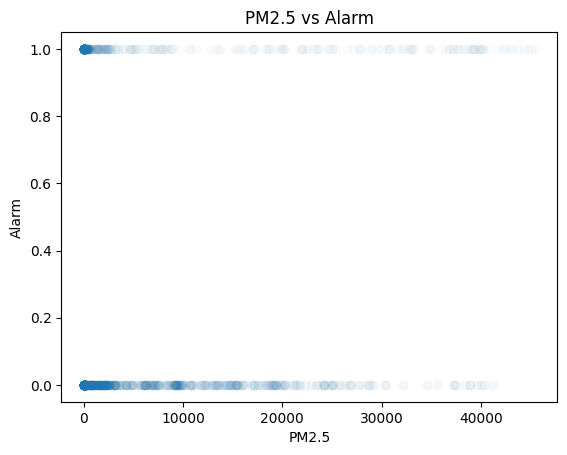

NC0.5


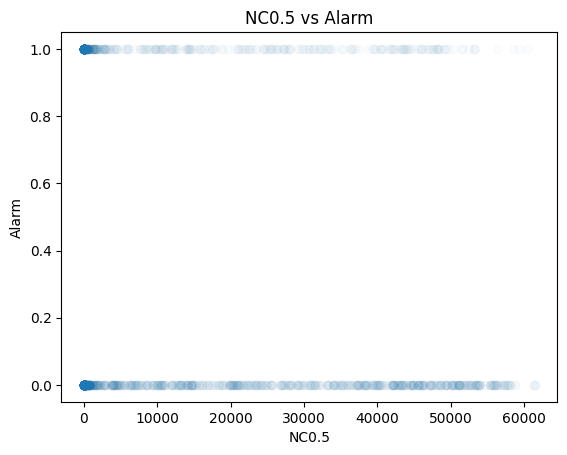

NC1.0


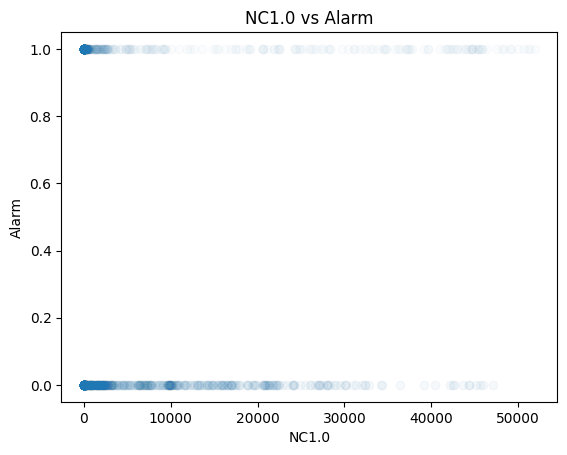

NC2.5


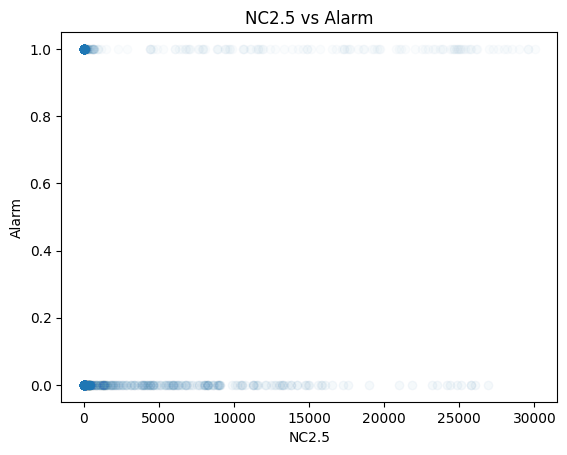

CNT


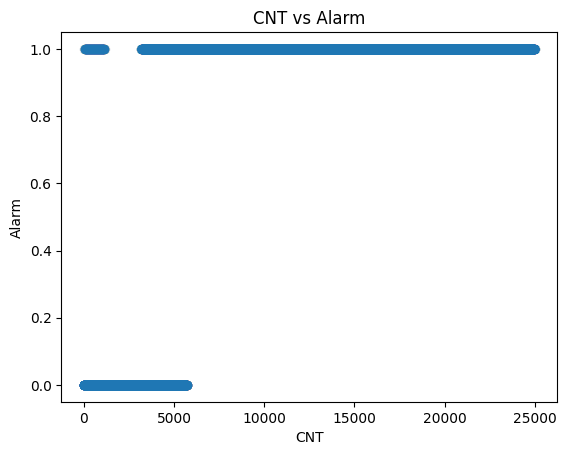

In [17]:
for feature in features:
    print(feature)
    plt.scatter(df[feature], y, alpha=0.02)
    plt.title(feature + " vs Alarm")
    plt.xlabel(feature)
    plt.ylabel("Alarm")
    plt.show()

Note: expecting to see a clear cutoff between some of the features vs alarm on or off. For instance, positive smoke detection for ethanol over 19000. Some data did not give a clear cutoff. Most likely, more than one factors are used to determine when the alarm goes off or not.

UTC


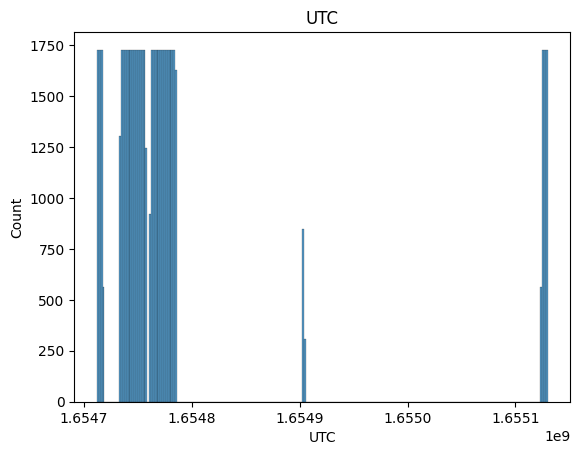

Temperature[C]


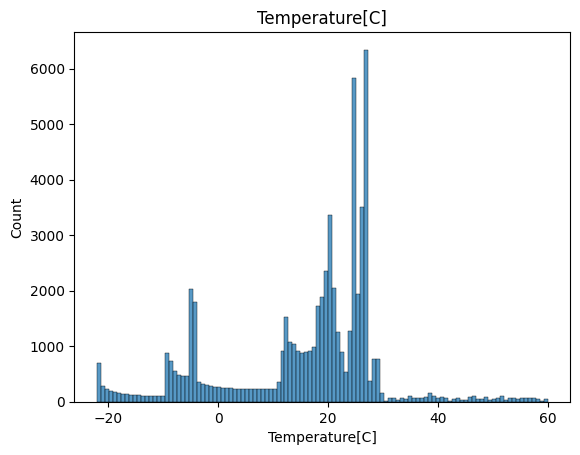

Humidity[%]


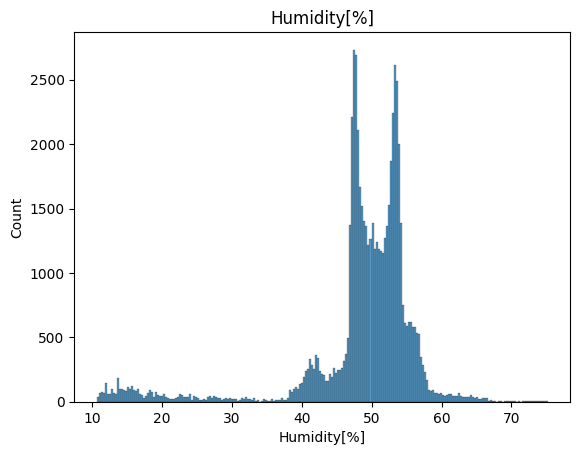

TVOC[ppb]


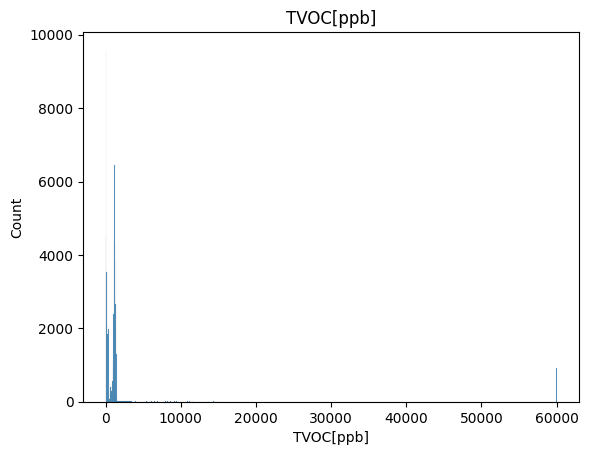

Raw H2


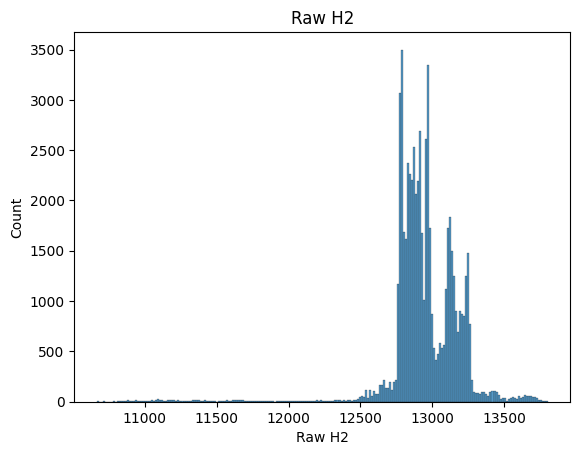

Raw Ethanol


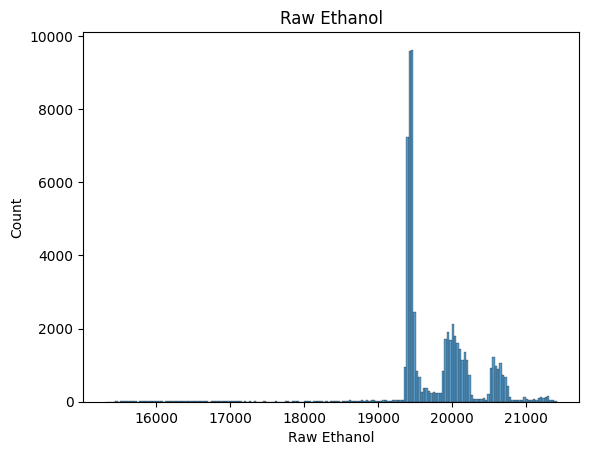

Pressure[hPa]


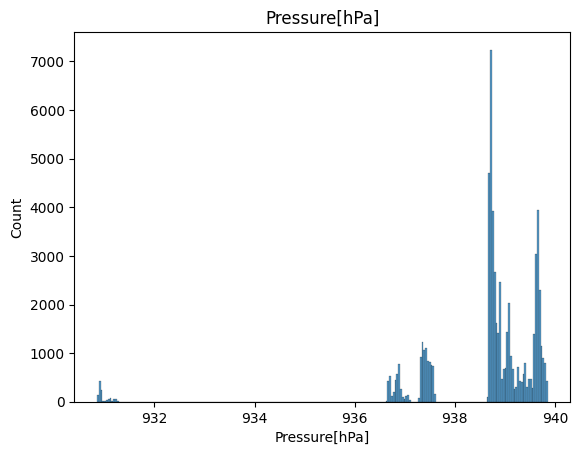

In [18]:
# Histograms for features of interest
features_for_plotting = ['UTC','Temperature[C]','Humidity[%]','TVOC[ppb]','Raw H2','Raw Ethanol','Pressure[hPa]']
for feature in features_for_plotting:
    print(feature)
    df_tmp = df.set_index(feature)
    sns.histplot(df[feature])
    plt.title(feature)
    plt.xlabel(feature)
    plt.show()

## Spliting Data to Train and Test Sets

In [19]:
target = ['Fire Alarm']
features = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]',
       'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5',
       'NC0.5', 'NC1.0', 'NC2.5', 'CNT']

## Spliting Data

In [20]:
# set time t
t = 5 #seconds

In [21]:
features

['Temperature[C]',
 'Humidity[%]',
 'TVOC[ppb]',
 'eCO2[ppm]',
 'Raw H2',
 'Raw Ethanol',
 'Pressure[hPa]',
 'PM1.0',
 'PM2.5',
 'NC0.5',
 'NC1.0',
 'NC2.5',
 'CNT']

In [22]:
# using the first 80% for training an the last 20% for validation
length = len(df)
df_train = df.head(int(length*0.8))[features + target]
df_test = df.tail(length- int(length*0.8))[features + target]

In [23]:
# reset the indices for cleanliness
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [24]:
df_train.shape

(50104, 15)

In [25]:
df_test.shape

(12526, 15)

In [26]:
# Create five minute input sequence and one minute predictive horizon
sequence_length = 5
# predictive horizon
ph = 1 

feature_cols = features

# create list of sequences of alarm readings used as features for training
sequences = [df_train[i:i+sequence_length+ph] for i in range(len(df_train)-sequence_length-ph)]

# convert to numpy arrays and floats to appease keras/tensorflow 
sequence_arrays = [val[features].head(sequence_length) for val in sequences]
sequence_labels = [val[target[0]].iloc[-1] for val in sequences]

# create list of sequences of alarm readings used as features for testing
test_sequences = [df_test[i:i+sequence_length+ph] for i in range(len(df_test)-sequence_length-ph)]

# convert to numpy arrays and floats to appease keras/tensorflow
# these can be used for validating the model after training
test_sequence_arrays = [val[features].head(sequence_length) for val in test_sequences]
test_sequence_labels = [val[target[0]].iloc[-1] for val in test_sequences]


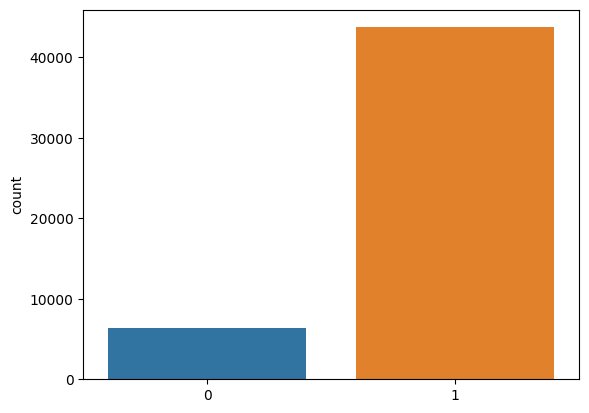

In [27]:
g=sns.countplot(x = np.array(sequence_labels))
plt.show()

As shown in the graph above, the data is highly imbalanced.

In [28]:

duplicated_arrays = []
duplicated_labels = []
# how many extra times to duplicate is number of 1s / number of 0s minus 1
times = int(sum(sequence_labels)/(len(sequence_labels)-sum(sequence_labels))) - 1
for i, label in enumerate(sequence_labels):
    if label==0:
        for i in range(times):
            duplicated_labels.append(label)
            duplicated_arrays.append(sequence_arrays[i])

In [29]:
# Checking to make sure they all have the right shape
sequence_arrays = np.array(sequence_arrays + duplicated_arrays)
sequence_labels = np.array(sequence_labels + duplicated_labels)
print(sequence_arrays.shape)
print(sequence_labels.shape)

(82018, 5, 13)
(82018,)


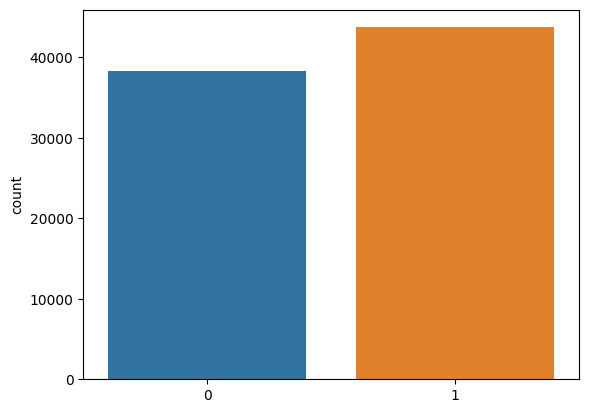

In [30]:
g=sns.countplot(x = np.array(sequence_labels))
plt.show()

The data is now almost pefectly balanced.

`sequence_arrays` can be used as features for training and `sequence_labels` are the labels to predict.

## Modeling

## References

1. Fire death and injury risk. U.S. Fire Administration. (2022, September 21). Retrieved February 19, 2023, from https://www.usfa.fema.gov/statistics/deaths-injuries/ 
2. How do smoke detectors work? (2022, March 2). NIST. Retrieved February 19, 2023, from https://www.nist.gov/how-do-you-measure-it/how-do-smoke-detectors-work
3. Zach, How to Test for Multicollinearity in Python. (2022, October 12). STATLOGY. Retrieved February 19, 2023 from https://www.statology.org/multicollinearity-in-python/